In [37]:
#Cargando librerías 
import importlib

import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd

import src.positioning_sensors as ps
import src.regionGrowing as rg
import src.manageExperiments as me
importlib.reload(ps)
importlib.reload(rg)
importlib.reload(me)

import src.network_fitness as netfit
importlib.reload(netfit)

from geneticalgorithm import geneticalgorithm as ga

plt.style.use("ggplot")

##
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.filters import rank

#import scipy.misc
#import numpy as np
from skimage.draw import line


In [38]:
fn = "config_exp_15062022_redo_exp.txt"


In [39]:

me.createProject(fn)

creating Directory exp_15062022_flat_is_decrease_redo/
Creating Directory exp_15062022_flat_is_decrease_redo/results/
Creating Directory exp_15062022_flat_is_decrease_redo/semivariances/
Copy config_exp_15062022_redo_exp.txt -> exp_15062022_flat_is_decrease_redo/config_exp_15062022_redo_exp.txt


In [40]:
setup = me.readConfigFile(fn)

In [41]:
flat_means_decrease = bool(setup['flatness_means_decrease'])
print(flat_means_decrease)

True


In [42]:

#cargamos imagenes en luminance e importance
ilumina = setup["folder_input"]+setup["input_ntli"]
niveles = setup["folder_input"]+setup["input_evm"]

#NTLI: luminance
NTLI = ps.readIMG(ilumina)

#EAM: Environtmental attention map is the importance
EAM = ps.readIMG(niveles,invert=True)

In [43]:



th = int(setup["desaturation_th"])

In [44]:
DNTLI,distance = ps.desaturate(NTLI,th=th)

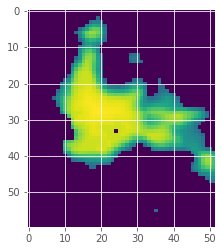

In [45]:
#smoothing parameters
sigma_y = setup['filterg_sy']
sigma_x =setup['filterg_sx']
sigma = [sigma_y,sigma_x]

FDNTLI = sp.ndimage.filters.gaussian_filter(DNTLI, sigma, mode=setup['gaussian_mode'])
#nonsat2 = luminance

#we filter only the values greater than 22
FDNTLI = (FDNTLI>=setup['neglect_values'])*FDNTLI
si = (33,24)
nonsatc = np.copy(FDNTLI)
nonsatc[si]=0
plt.imshow(nonsatc)
plt.show()

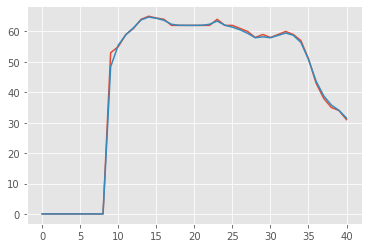

In [46]:
r = 20
#plt.plot(NTLI[si[0],si[1]-r:si[1]+r+1])
plt.plot(DNTLI[si[0],si[1]-r:si[1]+r+1])
plt.plot(FDNTLI[si[0],si[1]-r:si[1]+r+1])
#plt.vlines(si[1],0,np.max(nonsat2[si[0],:]))


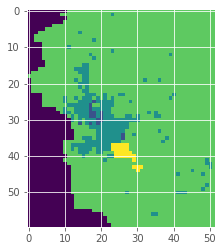

In [47]:
plt.imshow(EAM)

In [48]:
from IPython.display import clear_output

coords = ps.get_coords(FDNTLI>0)

#fill the required params
si = (37,18)

params = {"type": "semivar", 
          "atol": setup["tolerance_angle"], 
          "dtol": setup["tolerance_distance"]}


sv = np.zeros(FDNTLI.shape)

#tell to the class, which object is going to be used to make the semivariogram


rG = rg.rGrowing(FDNTLI)

rG.setParams(params)

n = len(coords)

#ncords x imagesize m x n
image_size = (n,FDNTLI.shape[0]*FDNTLI.shape[1])
allsemivariances = np.zeros(image_size)
allmask = np.zeros(image_size)


df = pd.DataFrame()



In [ ]:
for i,si in enumerate(coords):
    
    clear_output(wait=True)
    s="{percen: 1.2f}%"
    print(s.format(percen = 100*(i+1)/(n)))
    
    si = tuple(si)

    #generate a semivariance sv map

    sv = rG.makeSemivarianceMap(si)
    
    #flattne sv to store it in a dataframe
    allsemivariances[i] = sv.flatten()
    
    
    
    #construct a mask of sv and then flatten it
    allmask[i] = ps.constructMask(si,sv,flat_means_decrease).flatten()

 0.22%


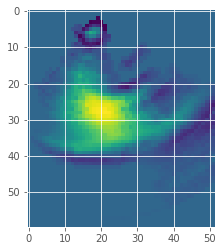

In [33]:
si = (2,19)
 #generate a semivariance sv map

sv = rG.makeSemivarianceMap(si)
plt.imshow(sv)

In [15]:
svm = ps.constructMask(si,sv,flat_means_decrease)

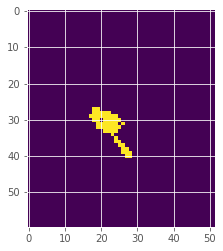

In [16]:
svm[si]=0
plt.imshow(svm)

In [17]:
rG.si = si
v = rG.getRegion(si)
v[si]=1

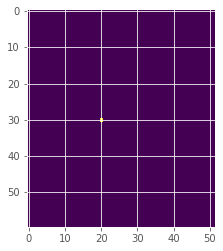

In [18]:
plt.imshow(v)

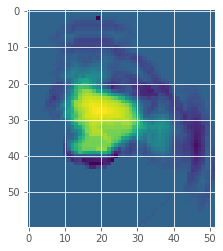

In [247]:
plt.imshow(allsemivariances[0].reshape(FDNTLI.shape))

In [248]:
sv = rG.makeSemivarianceMap(si)

In [19]:
filesv = setup["experiment_id"]+setup["folder_semivariances"]+setup["output_semivariances"]+".csv"
filesvmask = setup["experiment_id"]+setup["folder_semivariances"]+setup["output_semivariances"]+"mask.csv"


In [20]:

df_semivariance = pd.DataFrame(allsemivariances)
df_semivariance.insert(0,"coordsy",coords[:,0]) 
df_semivariance.insert(1,"coordsx",coords[:,1])
df_semivariance.to_csv(filesv)

df_semivariance_mask = pd.DataFrame(allmask)
df_semivariance_mask.insert(0,"coordsy",coords[:,0]) 
df_semivariance_mask.insert(1,"coordsx",coords[:,1])
df_semivariance_mask.to_csv(filesvmask)

In [22]:
si = (90,19)

params = {"type": "semivar", 
          "atol": setup["tolerance_angle"], 
          "dtol": setup["tolerance_distance"]}


sv = np.zeros(FDNTLI.shape)

#tell to the class, which object is going to be used to make the semivariogram


rG = rg.rGrowing(FDNTLI)

rG.setParams(params)

In [23]:
si

(90, 19)

In [24]:
sv = rG.makeSemivarianceMap((2,19))
    
#flattne sv to store it in a dataframe
allsemivariances = sv.flatten()

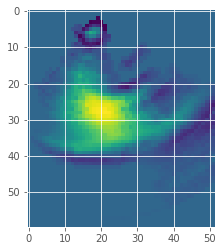

In [25]:
plt.imshow(sv)

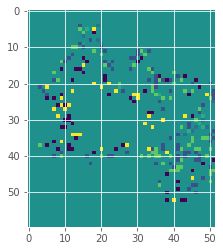

In [26]:
plt.imshow(allsemivariances.reshape(FDNTLI.shape))

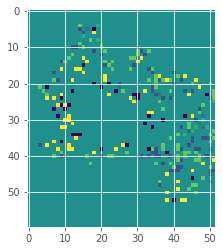

In [34]:
plt.imshow(variograms[0]-sv)

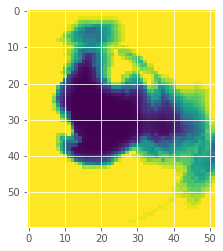

In [80]:
sv2 = rG.makeSemivarianceMap(si)
plt.imshow(sv2)

In [62]:


sv = rG.makeSemivarianceMap(si)

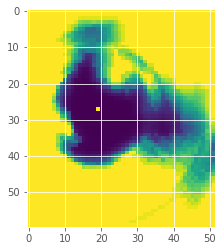

In [63]:
csv = np.copy(sv)
csv[si] = np.max(sv)
plt.imshow(csv)

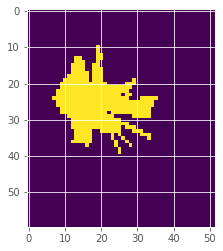

In [64]:
plt.imshow(ps.constructMask(si,sv,True)*(FDNTLI>0))

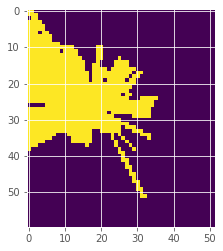

In [65]:
plt.imshow(ps.constructMask(si,sv,False))

### Verify .csv

In [27]:
filesv = setup["experiment_id"]+setup["folder_semivariances"]+setup["output_semivariances"]+".csv"
filesvmask = setup["experiment_id"]+setup["folder_semivariances"]+setup["output_semivariances"]+"mask.csv"

data = pd.read_csv(filesv)
data_m = pd.read_csv(filesvmask)

variogram_set = np.array(data.iloc[:,3:])
variogram_set_m = np.array(data_m.iloc[:,3:])
variograms = variogram_set.reshape(len(variogram_set),FDNTLI.shape[0],FDNTLI.shape[1])
variograms_m = variogram_set_m.reshape(len(variogram_set),FDNTLI.shape[0],FDNTLI.shape[1])
sensitivity = ps.f5(FDNTLI,EAM,1)
aptitude = netfit.NetworkFitness(FDNTLI,EAM,sensitivity,variograms,variograms_m,coords)

 W = i*a^(p)
Selct cost functions: 
 'xor','max' or 'cover'


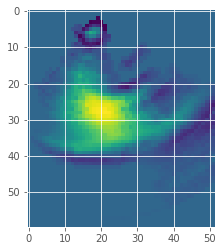

In [28]:
plt.imshow(variograms[0])

[0]


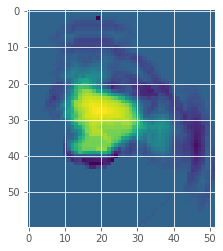

In [179]:
ix = aptitude.validate_coordinates(si[0],si[1])
print(ix)
csvsm = np.copy(variograms[ix][0])
plt.imshow(csvsm)

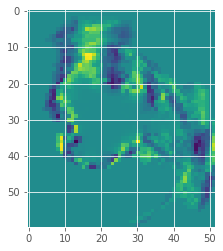

In [109]:
n = csvsm-sv2
plt.imshow(n)

In [44]:
plt.imshow(sm)

NameError: name 'sm' is not defined

In [90]:
((data["coordsy"]==si[0]) and  (data["coordsx"]==si[1]))

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [96]:
params = {"type": "semivar", 
          "si": si, 
          "atol": setup["tolerance_angle"], 
          "dtol": setup["tolerance_distance"]}


sv = np.zeros(luminance.shape)

#tell to the class, which object is going to be used to make the semivariogram


rG = rg.rGrowing(nonsat2)

rG.setParams(params)

sv = rG.makeSemivarianceMap(si)

In [118]:
data

,Unnamed: 0,coordsy,coordsx,0,1,2,3,4,5,6,...,3110,3111,3112,3113,3114,3115,3116,3117,3118,3119
0,0,2,19,291.654125,291.654125,291.654125,291.654125,291.654125,291.654125,291.654125,...,291.654125,291.654125,291.654125,291.654125,291.654125,291.654125,291.654125,291.654125,291.654125,291.654125
1,1,3,17,301.402967,301.402967,301.402967,301.402967,301.402967,301.402967,301.402967,...,301.402967,301.402967,301.402967,301.402967,301.402967,301.402967,301.402967,301.402967,301.402967,301.402967
2,2,3,18,443.744094,443.744094,443.744094,443.744094,443.744094,443.744094,443.744094,...,443.744094,443.744094,443.744094,443.744094,443.744094,443.744094,443.744094,443.744094,443.744094,443.744094
3,3,3,19,433.696100,433.696100,433.696100,433.696100,433.696100,433.696100,433.696100,...,433.696100,433.696100,433.696100,433.696100,433.696100,433.696100,433.696100,433.696100,433.696100,433.696100
4,4,3,20,333.394421,333.394421,333.394421,333.394421,333.394421,333.394421,333.394421,...,333.394421,333.394421,333.394421,333.394421,333.394421,333.394421,333.394421,333.394421,333.394421,333.394421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,901,46,50,413.698715,413.698715,413.698715,413.698715,413.698715,413.698715,413.698715,...,413.698715,413.698715,413.698715,413.698715,413.698715,413.698715,413.698715,413.698715,413.698715,413.698715
902,902,46,51,464.143246,464.143246,464.143246,464.143246,464.143246,464.143246,464.143246,...,464.143246,464.143246,464.143246,464.143246,464.143246,464.143246,464.143246,464.143246,464.143246,464.143246
903,903,47,50,309.648689,309.648689,309.648689,309.648689,309.648689,309.648689,309.648689,...,309.648689,309.648689,309.648689,309.648689,309.648689,309.648689,309.648689,309.648689,309.648689,309.648689
904,904,47,51,340.375672,340.375672,340.375672,340.375672,340.375672,340.375672,340.375672,...,340.375672,340.375672,340.375672,340.375672,340.375672,340.375672,340.375672,340.375672,340.375672,340.375672


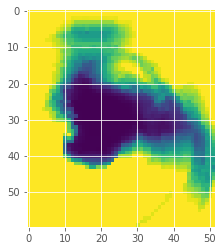

In [142]:
#gapminder.query('country=="United States" & year > 1996')
row = data.loc[(data['coordsy'] == si[0]) & (data['coordsx'] == si[1])]

sv_a = np.array(row)[0,3:].reshape(FDNTLI.shape)
plt.imshow(sv_a)

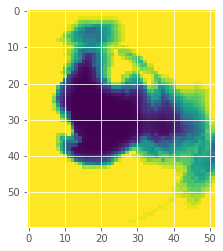

In [143]:
sv2 = rG.makeSemivarianceMap(si)
plt.imshow(sv2)

In [150]:
sk = (10,20)
sv2[sk]

1453.4075774431192

In [151]:
sv_a[sk]

1564.0033466001173

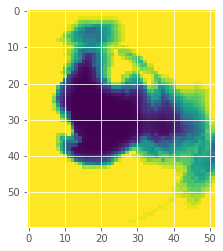

In [97]:
plt.imshow(sv)

In [98]:
si = (27,19)

params = {"type": "semivar", 
          "si": si, 
          "atol": setup["tolerance_angle"], 
          "dtol": setup["tolerance_distance"]}


sv = np.zeros(nonsat2.shape)

#tell to the class, which object is going to be used to make the semivariogram


rG = rg.rGrowing(nonsat2)

rG.setParams(params)

rG.makeSemivarianceMap(si)

array([[2242.80912909, 2242.80912909, 2242.80912909, ..., 2242.80912909,
        2242.80912909, 2242.80912909],
       [2242.80912909, 2242.80912909, 2242.80912909, ..., 2242.80912909,
        2242.80912909, 2242.80912909],
       [2242.80912909, 2242.80912909, 2242.80912909, ..., 2242.80912909,
        2242.80912909, 2242.80912909],
       ...,
       [2242.80912909, 2242.80912909, 2242.80912909, ..., 2242.80912909,
        2242.80912909, 2242.80912909],
       [2242.80912909, 2242.80912909, 2242.80912909, ..., 2242.80912909,
        2242.80912909, 2242.80912909],
       [2242.80912909, 2242.80912909, 2242.80912909, ..., 2242.80912909,
        2242.80912909, 2242.80912909]])

In [99]:
plt.imshow(ps.constructMask(si,sv))

TypeError: constructMask() missing 1 required positional argument: 'flatMeansDecrease'

In [77]:
sv[33,24:]

array([0.00000000e+00, 1.39162867e-01, 1.70074725e+00, 6.65967570e+00,
       1.53682726e+01, 2.67228672e+01, 6.90384956e+01, 6.59144411e+01,
       4.22185392e+01, 7.18544844e+01, 8.04448297e+01, 7.23802311e+01,
       4.82005779e+01, 7.79974332e+01, 7.96794817e+01, 9.52580655e+01,
       1.24036635e+02, 2.97241586e+02, 3.41780220e+02, 3.94642639e+02,
       4.21587883e+02, 4.59211007e+02, 4.97001455e+02, 6.08939449e+02,
       8.36514626e+02, 1.14154464e+03, 1.38142291e+03, 1.63511424e+03])

In [66]:
ps.detectRegion([0,1,2,3,4,5,5,5])

5

In [54]:
#cargamos imagenes en luminance e importance
ilumina = 'location/queretaro/qro_light_th'
niveles = 'location/queretaro/prioridades'
sigma_y = 0.5
sigma_x = 0.5
sigma = [sigma_y,sigma_x]

#Loading precalculated local and directed empirical variograms


#NLTI: luminance
luminance = ps.readIMG(ilumina)

#EAM: Environtmental attention map is the importance
EAM = ps.readIMG(niveles,invert=True)

In [57]:
nonsat,b = ps.desaturate(luminance,th=setup["desaturation_th"])




#nonsat2 = sp.ndimage.filters.gaussian_filter(nonsat, sigma, mode='constant')
#nonsat2 = (nonsat2>=22)*nonsat2

NLTI = sp.ndimage.filters.gaussian_filter(nonsat, sigma, mode='constant')
NLTI = (NLTI>=setup["neglect_values"])*NLTI